In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder 
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


For this section we will use the Kaggle otto challenge.
If you want to follow, Get the data from Kaggle: https://www.kaggle.com/c/otto-group-product-classification-challenge/data

#### About the data

The Otto Group is one of the world’s biggest e-commerce companies, A consistent analysis of the performance of products is crucial. However, due to diverse global infrastructure, many identical products get classified differently.
For this competition, we have provided a dataset with 93 features for more than 200,000 products. The objective is to build a predictive model which is able to distinguish between our main product categories. 
Each row corresponds to a single product. There are a total of 93 numerical features, which represent counts of different events. All features have been obfuscated and will not be defined any further.

https://www.kaggle.com/c/otto-group-product-classification-challenge/data

In [3]:
def load_data(path, train=True):
    """Load data from a CSV File
    
    Parameters
    ----------
    path: str
        The path to the CSV file
        
    train: bool (default True)
        Decide whether or not data are *training data*.
        If True, some random shuffling is applied.
        
    Return
    ------
    X: numpy.ndarray 
        The data as a multi dimensional array of floats
    ids: numpy.ndarray
        A vector of ids for each sample
    """
    df = pd.read_csv(path)
    X = df.values.copy()
    if train:
        np.random.shuffle(X)  # https://youtu.be/uyUXoap67N8
        X, labels = X[:, 1:-1].astype(np.float32), X[:, -1]
        return X, labels
    else:
        X, ids = X[:, 1:].astype(np.float32), X[:, 0].astype(str)
        return X, ids

In [6]:
def preprocess_data(X, scaler=None):
    """Preprocess input data by standardise features 
    by removing the mean and scaling to unit variance"""
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler


def preprocess_labels(labels, encoder=None, categorical=True):
    """Encode labels with values among 0 and `n-classes-1`"""
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
    y = encoder.transform(labels).astype(np.int32)
    if categorical:
        y = np_utils.to_categorical(y)
    return y, encoder

NameError: name 'X' is not defined

In [7]:
print("Loading data...")
X, labels = load_data('/home/ubuntu/deep-learning-keras-tensorflow/data/train.csv', train=True)
X_orig = X.copy()
X, scaler = preprocess_data(X)
Y, encoder = preprocess_labels(labels)


X_test, ids = load_data('/home/ubuntu/deep-learning-keras-tensorflow/data/test.csv', train=False)
X_test, ids = X_test[:1000], ids[:1000]

#Plotting the data
print(X_test[:1])

X_test, _ = preprocess_data(X_test, scaler)


nb_classes = Y.shape[1]
print(nb_classes, 'classes')

dims = X.shape[1]
print(dims, 'dims')

Loading data...
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   3.   0.   0.   0.   3.
    2.   1.   0.   0.   0.   0.   0.   0.   0.   5.   3.   1.   1.   0.
    0.   0.   0.   0.   1.   0.   0.   1.   0.   1.   0.   1.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   3.   0.   0.   0.   0.   1.   1.
    0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.  11.   1.  20.   0.   0.   0.   0.   0.]]
9 classes
93 dims


In [8]:
X_orig

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  3.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  5.,  0.],
       [ 0.,  0.,  9., ...,  0.,  1.,  0.]], dtype=float32)

In [11]:
np.std(X)

0.99998945

Now lets create and train a logistic regression model.

---

# Keras

## Deep Learning library for Theano and TensorFlow

Keras is a minimalist, highly modular neural networks library, written in Python and capable of running on top of either TensorFlow or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.
ref: https://keras.io/

## Why this name, Keras?

Keras (κέρας) means _horn_ in Greek. It is a reference to a literary image from ancient Greek and Latin literature, first found in the _Odyssey_, where dream spirits (_Oneiroi_, singular _Oneiros_) are divided between those who deceive men with false visions, who arrive to Earth through a gate of ivory, and those who announce a future that will come to pass, who arrive through a gate of horn. It's a play on the words κέρας (horn) / κραίνω (fulfill), and ἐλέφας (ivory) / ἐλεφαίρομαι (deceive).

Keras was initially developed as part of the research effort of project ONEIROS (Open-ended Neuro-Electronic Intelligent Robot Operating System).

>_"Oneiroi are beyond our unravelling --who can be sure what tale they tell? Not all that men look for comes to pass. Two gates there are that give passage to fleeting Oneiroi; one is made of horn, one of ivory. The Oneiroi that pass through sawn ivory are deceitful, bearing a message that will not be fulfilled; those that come out through polished horn have truth behind them, to be accomplished for men who see them."_ Homer, Odyssey 19. 562 ff (Shewring translation).

## Hands On - Keras Logistic Regression


In [6]:
dims = X.shape[1] #number of features in our data  - 93
print(dims, 'dims')
print("Building model...")

nb_classes = Y.shape[1] #number of classes in our data - 9
print(nb_classes, 'classes')

model = Sequential() #intialize a model
model.add(Dense(nb_classes, input_shape=(dims,))) #add a fully connected layer with 9 neurons
model.add(Activation('softmax')) #add softmax activation

model.compile(optimizer='sgd', loss='categorical_crossentropy') #add the sgd optimizer to optimize our model 
model.fit(X, Y) #start optimizing 

93 dims
Building model...
9 classes
Epoch 1/1
61878/61878 [==============================] - 2s 30us/step - loss: 1.0424


In [7]:
train_predictions = model.predict(X).argmax(axis=1)

In [8]:
print('train accuracy is {0}'.format(sum(Y.argmax(axis=1)==train_predictions)/train_predictions.shape[0]))

train accuracy is 0.7260738873266751


Simplicity is pretty impressive right? :)

Now lets understand:
<pre>The core data structure of Keras is a <b>model</b>, a way to organize layers. The main type of model is the <b>Sequential</b> model, a linear stack of layers.</pre>


What we did here is stacking a Fully Connected (<b>Dense</b>) layer of trainable weights from the input to the output and an <b>Activation</b> layer on top of the weights layer.

##### Dense

```python
from keras.layers.core import Dense

Dense(output_dim, init='glorot_uniform', activation='linear', 
      weights=None, W_regularizer=None, b_regularizer=None,
      activity_regularizer=None, W_constraint=None, 
      b_constraint=None, bias=True, input_dim=None)
```

##### Activation

```python
from keras.layers.core import Activation

Activation(activation)
```

##### Optimizer

If you need to, you can further configure your optimizer. A core principle of Keras is to make things reasonably simple, while allowing the user to be fully in control when they need to (the ultimate control being the easy extensibility of the source code).
Here we used <b>SGD</b> (stochastic gradient descent) as an optimization algorithm for our trainable weights.  

"Data Sciencing" this example a little bit more
=====

What we did here is nice, however in the real world it is not useable because of overfitting.
Lets try and solve it with cross validation.

##### Overfitting

In overfitting, a statistical model describes random error or noise instead of the underlying relationship. Overfitting occurs when a model is excessively complex, such as having too many parameters relative to the number of observations. 

A model that has been overfit has poor predictive performance, as it overreacts to minor fluctuations in the training data.


<img src ="imgs/overfitting.png">

<pre>To avoid overfitting, we will first split out data to training set and test set and test out model on the test set.
Next: we will use two of keras's callbacks <b>EarlyStopping</b> and <b>ModelCheckpoint</b></pre>

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=42)

fBestModel = 'best_model.h5' 
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1) 
best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)

model.fit(X_train, Y_train, validation_data = (X_val, Y_val), nb_epoch=20, 
          batch_size=128, verbose=True, validation_split=0.15, 
          callbacks=[best_model, early_stop])

Train on 52596 samples, validate on 9282 samples
Epoch 1/20
13824/52596 [======>.......................] - ETA: 0s - loss: 0.8194

/home/ubuntu/anaconda2/envs/deep-learning/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


52596/52596 [==============================] - 1s 13us/step - loss: 0.8019 - val_loss: 0.7711
Epoch 2/20
52596/52596 [==============================] - 1s 12us/step - loss: 0.7834 - val_loss: 0.7549
Epoch 3/20
52596/52596 [==============================] - 1s 12us/step - loss: 0.7691 - val_loss: 0.7421
Epoch 4/20
52596/52596 [==============================] - 1s 13us/step - loss: 0.7577 - val_loss: 0.7316
Epoch 5/20
52596/52596 [==============================] - 1s 12us/step - loss: 0.7484 - val_loss: 0.7226
Epoch 6/20
52596/52596 [==============================] - 1s 12us/step - loss: 0.7405 - val_loss: 0.7152
Epoch 7/20
52596/52596 [==============================] - 1s 11us/step - loss: 0.7338 - val_loss: 0.7086
Epoch 8/20
52596/52596 [==============================] - 1s 11us/step - loss: 0.7279 - val_loss: 0.7027
Epoch 9/20
52596/52596 [==============================] - 1s 11us/step - loss: 0.7229 - val_loss: 0.6980
Epoch 10/20
52596/52596 [==============================] - 1s 11us

In [10]:
train_predictions = model.predict(X_train).argmax(axis=1)
print('train accuracy is {0}'.format(sum(Y_train.argmax(axis=1)==train_predictions)/train_predictions.shape[0]))

train accuracy is 0.7491444216290212


In [11]:
val_predictions = model.predict(X_val).argmax(axis=1)
print('test accuracy is {0}'.format(sum(Y_val.argmax(axis=1)==val_predictions)/val_predictions.shape[0]))

test accuracy is 0.7557638439991381


## Multi-Layer Perceptron and Fully Connected

So, how hard can it be to build a Multi-Layer percepton with keras?
It is baiscly the same, just add more layers!

In [12]:
model = Sequential()
model.add(Dense(100, input_shape=(dims,)))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy')
model.fit(X_train, Y_train, validation_data = (X_val, Y_val), nb_epoch=20, 
          batch_size=128, verbose=True, validation_split=0.15, 
          callbacks=[best_model, early_stop]) 

/home/ubuntu/anaconda2/envs/deep-learning/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 52596 samples, validate on 9282 samples
Epoch 1/20
52596/52596 [==============================] - 1s 19us/step - loss: 1.1997 - val_loss: 0.8781
Epoch 2/20
52596/52596 [==============================] - 1s 16us/step - loss: 0.8304 - val_loss: 0.7738
Epoch 3/20
52596/52596 [==============================] - 1s 19us/step - loss: 0.7672 - val_loss: 0.7297
Epoch 4/20
52596/52596 [==============================] - 1s 15us/step - loss: 0.7354 - val_loss: 0.7046
Epoch 5/20
52596/52596 [==============================] - 1s 14us/step - loss: 0.7160 - val_loss: 0.6879
Epoch 6/20
52596/52596 [==============================] - 1s 14us/step - loss: 0.7028 - val_loss: 0.6755
Epoch 7/20
52596/52596 [==============================] - 1s 14us/step - loss: 0.6933 - val_loss: 0.6673
Epoch 8/20
52596/52596 [==============================] - 1s 14us/step - loss: 0.6859 - val_loss: 0.6602
Epoch 9/20
52596/52596 [==============================] - 1s 14us/step - loss: 0.6802 - val_loss: 0.6555
Epoch 

In [13]:
train_predictions = model.predict(X_train).argmax(axis=1)
print('train accuracy is {0}'.format(sum(Y_train.argmax(axis=1)==train_predictions)/train_predictions.shape[0]))

train accuracy is 0.7587649250893604


In [14]:
val_predictions = model.predict(X_val).argmax(axis=1)
print('test accuracy is {0}'.format(sum(Y_val.argmax(axis=1)==val_predictions)/val_predictions.shape[0]))

test accuracy is 0.7670760611937083


Your Turn!

## Hands On - Keras Fully Connected


Take couple of minutes and Try and optimize the number of layers and the number of parameters in the layers to get the best results. 

In [16]:
model = Sequential()
model.add(Dense(100, input_shape=(dims,)))
# Play with it! add as much layers as you want! try and get better results.
model.add(Dense(100))
model.add(Dense(512))
model.add(Dense(512))
model.add(Dense(100))
model.add(Dense(nb_classes))

model.add(Activation('softmax'))

model.compile(optimizer='sgd', loss='categorical_crossentropy')

model.fit(X_train, Y_train, validation_data = (X_val, Y_val), nb_epoch=50, 
          batch_size=128, verbose=True, validation_split=0.15, 
          callbacks=[best_model, early_stop]) 

/home/ubuntu/anaconda2/envs/deep-learning/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 52596 samples, validate on 9282 samples
Epoch 1/50
52596/52596 [==============================] - 6s 108us/step - loss: 0.8818 - val_loss: 0.7093
Epoch 2/50
52596/52596 [==============================] - 5s 97us/step - loss: 0.7131 - val_loss: 0.6717
Epoch 3/50
52596/52596 [==============================] - 5s 102us/step - loss: 0.6871 - val_loss: 0.6597
Epoch 4/50
52596/52596 [==============================] - 6s 105us/step - loss: 0.6753 - val_loss: 0.6488
Epoch 5/50
52596/52596 [==============================] - 5s 87us/step - loss: 0.6669 - val_loss: 0.6400
Epoch 6/50
52596/52596 [==============================] - 5s 97us/step - loss: 0.6634 - val_loss: 0.6355
Epoch 7/50
52596/52596 [==============================] - 5s 87us/step - loss: 0.6596 - val_loss: 0.6359
Epoch 8/50
52596/52596 [==============================] - 6s 106us/step - loss: 0.6567 - val_loss: 0.6336
Epoch 9/50
52596/52596 [==============================] - 5s 99us/step - loss: 0.6561 - val_loss: 0.6367
Ep

In [17]:
train_predictions = model.predict(X).argmax(axis=1)
print('train accuracy is {0}'.format(sum(Y.argmax(axis=1)==train_predictions)/train_predictions.shape[0]))

train accuracy is 0.7642134522770613


In [18]:
val_predictions = model.predict(X_val).argmax(axis=1)
print('test accuracy is {0}'.format(sum(Y_val.argmax(axis=1)==val_predictions)/val_predictions.shape[0]))

test accuracy is 0.7693385046326223


### Let's overfit it

In [19]:
model = Sequential()
model.add(Dense(512, input_shape=(dims,)))
# Play with it! add as much layers as you want! try and get better results.
model.add(Dense(512))
model.add(Dense(512))
model.add(Dense(512))
model.add(Dense(512))
model.add(Dense(512))
model.add(Dense(nb_classes))

model.add(Activation('softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy')
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), nb_epoch=30, 
          batch_size=128, verbose=True, validation_split=0.15, ) 

/home/ubuntu/anaconda2/envs/deep-learning/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 52596 samples, validate on 9282 samples
Epoch 1/30
52596/52596 [==============================] - 15s 287us/step - loss: 0.7898 - val_loss: 0.6634
Epoch 2/30
52596/52596 [==============================] - 15s 286us/step - loss: 0.6838 - val_loss: 0.6432
Epoch 3/30
52596/52596 [==============================] - 15s 283us/step - loss: 0.6698 - val_loss: 0.6380
Epoch 4/30
52596/52596 [==============================] - 15s 285us/step - loss: 0.6650 - val_loss: 0.6396
Epoch 5/30
52596/52596 [==============================] - 15s 290us/step - loss: 0.6611 - val_loss: 0.6320
Epoch 6/30
52596/52596 [==============================] - 16s 295us/step - loss: 0.6584 - val_loss: 0.6292
Epoch 7/30
52596/52596 [==============================] - 15s 285us/step - loss: 0.6567 - val_loss: 0.6305
Epoch 8/30
52596/52596 [==============================] - 16s 295us/step - loss: 0.6551 - val_loss: 0.6276
Epoch 9/30
52596/52596 [==============================] - 16s 311us/step - loss: 0.6535 - val_l

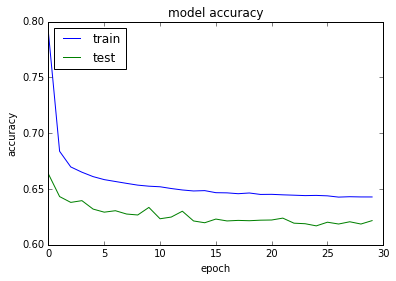

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

Building a question answering system, an image classification model, a Neural Turing Machine, a word2vec embedder or any other model is just as fast. The ideas behind deep learning are simple, so why should their implementation be painful?

#### Theoretical Motivations for depth

>Much has been studied about the depth of neural nets. Is has been proven mathematically[1] and empirically that convolutional neural network benifit from depth! 

[1] - On the Expressive Power of Deep Learning: A Tensor Analysis - Cohen, et al 2015

#### Theoretical Motivations for depth

One much quoted theorem about neural network states that:

>Universal approximation theorem states[1] that a feed-forward network with a single hidden layer containing a finite number of neurons (i.e., a multilayer perceptron), can approximate continuous functions on compact subsets of $\mathbb{R}^n$, under mild assumptions on the activation function. The theorem thus states that simple neural networks can represent a wide variety of interesting functions when given appropriate parameters; however, it does not touch upon the algorithmic learnability of those parameters.

[1] - Approximation Capabilities of Multilayer Feedforward Networks - Kurt Hornik 1991